# 社群媒體分析LabStudy 3-第4組
## 專案主題：PTT網友對於高嘉瑜事件的討論
成員：M092040020 陳佳伶、M094020038 李佳蓉、M104020011 王培碩、M104020013 黃威凱、M104020048 顏宏任、M104020029 邱承漢

## 大綱
1. 動機與分析目的
2. 分析方向及工具
3. 基本資料介紹
4. 主題模型
  + 訓練LDA模型
  + 查看LDA主題代表字
  + 查看LDA模型指標
  + 透過指標找出最佳主題數
  + 產生 LDAvis 結果
  + 查看 Document 主題時間上分佈
5. 基本圖學理論&igraph
6. 社會網路分析
  + 結論

## 1.動機與分析目的
高嘉瑜受家暴的事件在2021年11月30日被爆料出來，後續事件如滾雪球般越滾越大，隨著事情的演進，讓高女前男友的種種惡行曝了光。為了探究這次事件的討論主題及人物關聯，因此我們針對這次PTT上網友的討論進行了本次的研究及分析。

## 2.分析方向及工具
1. 主題模型，用來分析文章主題的類別。
2. 基本圖學，可以用來找出人物之間的關係圖。
3. 社會網路分析，透過LDA為資料進行的主題分析，再以不同角度對社群進行篩選分析。

## 3.基本資料介紹
* 資料來源：文字平台 PTT Gossip八卦板
* 資料集：高嘉瑜_articleMetaData.csv、高嘉瑜_articleReviews.csv
* 關鍵字：高嘉瑜、林炳書、林秉樞
* 資料時間：2021-11-29 ～ 2021-12-06
* 資料量： 1,539 篇文章、144,731 個留言

## 4. 載入套件

In [1]:
#!pip install gensim
#!pip install pyLDAvis
#!pip install pyvis

In [2]:
import pandas as pd
import jieba
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models
import numpy as np
import jieba.analyse
import IPython
from pyvis.network import Network
from itertools import permutations
from datetime import datetime
from wordcloud import WordCloud 
import math
from nltk import ngrams
from collections import defaultdict
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models
import time

In [128]:
#中文文字顯示設定
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'/Users/ASUS/anaconda3/Lib/site-packages/matplotlib/mpl-data/fonts/ttf/msj.ttf')
plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] #使中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯示

In [4]:
# 設定圖的字體大小
font = {'size':14}
matplotlib.rc('font', **font)

C:\Users\ASUS\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# 移除警告語，視覺上比較乾淨
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\ASUS\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 4.1 資料前處理
匯入「高嘉瑜_articleMetaData.csv」檔案，並且清理文句。

In [6]:
# 匯入資料
data = pd.read_csv('./raw_data/高嘉瑜_articleMetaData.csv', encoding='UTF-8')

In [7]:
#移除PTT貼新聞時會出現的格式用字
data['sentence'] = data.sentence.apply(lambda x: re.sub('(媒體來源|記者署名|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除)', '', str(x)))
data['sentence'] = data.sentence.apply(lambda x: re.sub('(http|https)://.*', '', x))
data['sentence'] = data.sentence.apply(lambda x: re.sub('\n', ',', x))
data['sentence'] = data.sentence.apply(lambda x: re.sub('[a-zA-Z0-9]+', ',', x))

+ 來源：文字平台 PTT Gossip八卦板
+ 時間：2021/11/29 到 2021/12/06，隨機選1000篇新聞。

In [8]:
metadata = data.sample(n=1000, random_state=2021).reset_index(drop=True)

**查看「高嘉瑜、林炳書、林秉樞」的相關貼文在時間上的數量走勢** <br>
+ 將資料中「artDate」(貼文日期)groupby起來，並計算數量。
+ 日期資料轉換為日期格式，之後圖示會幫助閱讀。

In [9]:
# groupby artDate 轉為新的DataFrame
day_count = pd.DataFrame({
    'date': metadata.groupby('artDate').size().index,
    'count': metadata.groupby('artDate').size().values
})
day_count = day_count.sort_values(by='date') # 排序
day_count.date = pd.to_datetime(day_count['date']) # 將裡面資料轉為日期格式

+ 觀察折線圖，可以發現高嘉瑜的相關文章篇數在11/30開始急速攀升，而接著則漸漸下降。
+ 12/05，高嘉瑜首度現身說明，因此又衝起了一次高峰。

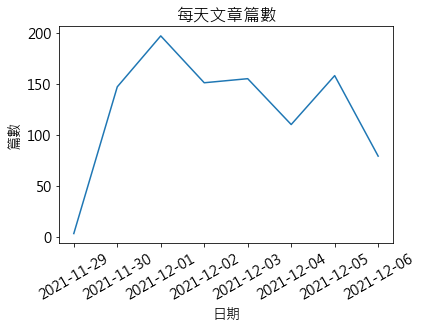

In [10]:
plt.plot(day_count['date'], day_count['count'])
plt.title('每天文章篇數') # 標題
plt.xlabel('日期') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30) # 旋轉x刻度避免重疊
plt.show()

**4.2 Jieba中文斷詞、匯入字典**

斷詞引擎設定：使用 Jieba 當作斷詞系統。<br>

Jieba 原先內建為簡體字字典，因此我們匯入繁體字典，斷詞結果會比較好。<br>
另外，在一些特殊主題裡，會有獨特的專有名詞，因此我們需要加入這些字詞進去。<br>
兩種方式：1.匯入檔案 2.參數形式手動加入

以下用匯入檔案的方式：

In [11]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
jieba.set_dictionary('./dict/dict.txt') 

# 自定義辭典
print("--> 匯入自定義字典，這裡匯入關於事件人的名稱")
jieba.load_userdict('./dict/user_dict.txt')

Building prefix dict from C:\Users\ASUS\jupyter\第三次讀書會\dict\dict.txt ...
Loading model from cache C:\Users\ASUS\AppData\Local\Temp\jieba.u200be915d161613eb6da0387f51f6da5.cache


--> 匯入自定義字典，這裡匯入關於事件人的名稱


Loading model cost 0.491 seconds.
Prefix dict has been built successfully.


In [12]:
# 資料進行斷詞，為list的格式
data = metadata[['artUrl','sentence']].astype(str)
token_df = data.assign(wordlist = data['sentence'].apply(jieba.lcut))

print("資料斷詞後的 DataFrame：artUrl(連結)、sentence(文章)、wordlist(斷詞)")
token_df.head(3)

資料斷詞後的 DataFrame：artUrl(連結)、sentence(文章)、wordlist(斷詞)


,artUrl,sentence,wordlist
0,https://www.ptt.cc/bbs/Gossiping/M.1638357037....,"大家好，我大麻莉絲啦,關於這個林秉樞我剛好也是略懂略懂,大概是,年左右我還在歐洲大陸當一個迷...","[大家, 好, ，, 我, 大麻, 莉絲, 啦, ,, 關於, 這個, 林秉樞, 我, 剛好..."
1,https://www.ptt.cc/bbs/Gossiping/M.1638507424....,"想來真的恐怖,, 這個人又暴力又邪惡,, 還能控制別人心靈跟,網軍,, 出事還有...","[想來, 真的, 恐怖, ,, ,, , , , 這個, 人, 又, 暴力, 又, 邪..."
2,https://www.ptt.cc/bbs/Gossiping/M.1638700902....,"「我也被騙了」公關公司不斷帶風向偽裝被害人,,從毒油事件再到台鐵現在劇情開到了林秉樞,,「高...","[「, 我, 也, 被, 騙, 了, 」, 公關, 公司, 不斷, 帶, 風向, 偽裝, 被..."


**4.3 去除停用字**

為了提高準確度，我們會將停用字移除，例如：空格、標點符號、語助詞...等。<br>
兩種方式： 1.匯入檔案 2.參數形式手動加入

以下使用匯入檔案的方式：

In [13]:
stopwords = []

#匯入檔案
with open(f'./dict/stopwords.txt','r',encoding="utf-8") as f:
    stopwords = f.read().splitlines() #移除換行符號\n

print("stropwords儲存為list形式，前幾個為：")
stopwords[:15]

stropwords儲存為list形式，前幾個為：


['$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”']

除了移除停用字，也可以設定其他條件。
+ 字的長度要大於一
+ 只選沒有在停用字點裡的字
+ 用正規表達式移除，舉例：\d 移除數字

In [14]:
# 移除停用字的 function
def remove_stop(listt):
    result = [re.sub(r'\d|-', '', word) for word in listt]
    result = [word for word in result if len(word)>1] 
    result = list(filter(lambda x : x not in stopwords, result)) 
    return result

In [15]:
# list 刪掉 stopwords
token_df = token_df.assign( remove_stopwords = token_df['wordlist'].apply(remove_stop))
print("remove_stopwords 為 wordlist 移除停用字後的結果：")
token_df.head(3)

remove_stopwords 為 wordlist 移除停用字後的結果：


,artUrl,sentence,wordlist,remove_stopwords
0,https://www.ptt.cc/bbs/Gossiping/M.1638357037....,"大家好，我大麻莉絲啦,關於這個林秉樞我剛好也是略懂略懂,大概是,年左右我還在歐洲大陸當一個迷...","[大家, 好, ，, 我, 大麻, 莉絲, 啦, ,, 關於, 這個, 林秉樞, 我, 剛好...","[大麻, 莉絲, 林秉樞, 懂略, 左右, 歐洲, 大陸, 當一個, 迷途, 毒蟲, 臉書,..."
1,https://www.ptt.cc/bbs/Gossiping/M.1638507424....,"想來真的恐怖,, 這個人又暴力又邪惡,, 還能控制別人心靈跟,網軍,, 出事還有...","[想來, 真的, 恐怖, ,, ,, , , , 這個, 人, 又, 暴力, 又, 邪...","[想來, 恐怖, 暴力, 邪惡, 控制, 心靈, 網軍, 出事, 詹宏志, 宣明智, 綠營,..."
2,https://www.ptt.cc/bbs/Gossiping/M.1638700902....,"「我也被騙了」公關公司不斷帶風向偽裝被害人,,從毒油事件再到台鐵現在劇情開到了林秉樞,,「高...","[「, 我, 也, 被, 騙, 了, 」, 公關, 公司, 不斷, 帶, 風向, 偽裝, 被...","[公關, 公司, 不斷, 風向, 偽裝, 被害人, 毒油, 事件, 台鐵, 現在, 劇情, ..."


**4.4 LDA 主題模型**

Latent Dirichlet allocation 簡稱 LDA，是一種主題模型，他可以將資料集中每篇文檔的主題按照機率分佈，他是無監督學習法，訓練時不需要手動標註，只需要給文黨集、主題數，也可以根據一些參數(alpha、Beta)來改變模型訓練的結果，以下使用 gensim 套件來示範如何訓練 LDA 模型。

**4.4.1 訓練 LDA 模型**

將文章斷詞結果儲存為 list 資料形態，一篇文章為一個 list ，其中 element 為詞彙。

In [16]:
token_data = token_df['remove_stopwords'].tolist()

In [17]:
for i in range(0,3):
    print("第 " + str(i+1) + " 篇文章前10個字：")
    for j in range(0,10):
        print(token_data[i][j], end=' ')
    print('\n')

第 1 篇文章前10個字：
大麻 莉絲 林秉樞 懂略 左右 歐洲 大陸 當一個 迷途 毒蟲 

第 2 篇文章前10個字：
想來 恐怖 暴力 邪惡 控制 心靈 網軍 出事 詹宏志 宣明智 

第 3 篇文章前10個字：
公關 公司 不斷 風向 偽裝 被害人 毒油 事件 台鐵 現在 



id2word 將斷詞結果生成字典，裡頭為資料集裡出現的字。

In [18]:
id2word = corpora.Dictionary(token_data)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(15638 unique tokens: ['一句', '一問', '一種', '一路', '一陣']...)


將斷詞結果建構語料庫(corpus)，利用語料庫把每篇文章數字化。<br>
每篇文章、每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[0]:[(0, 1), (1, 1), (2, 3), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表：'高嘉瑜'出現一次'、'一再'出現一次、'一同'出現三次...以此類推

In [19]:
corpus = [id2word.doc2bow(text) for text in token_data]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 3), (7, 2), (8, 2), (9, 1)]


參數說明：
+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [20]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus, 
    id2word=id2word, # 字典
    num_topics=4, # 生成幾個主題數
    random_state=1005, # 亂數
    iterations = 1000,
    passes=5, # 模型訓練次數
)

**4.4.2 查看 LDA 主題代表字** <br>

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>

舉例來說：<br>
(0, '0.015*"民進黨" + 0.011*"立委" + 0.006*"台灣" + 0.004*"中共" ...)<br>
-> 第一個主題的詞彙分佈，0.015:民進黨、0.011:立委、0.006:台灣...（全部詞彙加起來會等於一）

In [21]:
# 每個主題重要的前五個關鍵字
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.015*"民進黨" + 0.011*"立委" + 0.006*"台灣" + 0.004*"中共" + 0.004*"同路人"')
(1, '0.012*"高嘉瑜" + 0.006*"林秉樞" + 0.005*"林男" + 0.005*"知道" + 0.005*"民進黨"')
(2, '0.023*"林秉樞" + 0.017*"高嘉瑜" + 0.011*"網軍" + 0.007*"民進黨" + 0.006*"立委"')
(3, '0.019*"高嘉瑜" + 0.019*"林秉樞" + 0.007*"立委" + 0.006*"男友" + 0.005*"飯店"')


我們可以根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：
+ 主題一：民進黨跟中共間的關係
+ 主題二：高嘉瑜跟林秉樞之間的關係
+ 主題三：林秉樞的網軍與民進黨的關係
+ 主題四：高嘉瑜立委的男友

**4.4.3 查看 LDA 模型指標**
+ **Pointwise Mutual Information** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [22]:
PMI_model_lda = CoherenceModel(model=ldamodel, texts=token_data, coherence='c_uci')
PMI_lda = PMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', PMI_lda)

這個主題的 PMI score:  -1.0554036223525134


In [23]:
perplexity = ldamodel.log_perplexity(corpus)
print('這個主題的 Perplexity Score: ', perplexity)

這個主題的 Perplexity Score:  -8.648370329344063


**4.4.4 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡以 perplexity 為指標，因為gensim套件的問題，我們將其進行轉換。<br>
這裡我們選擇主題數 4 來做分析。

**再次強調**：主題數及參數沒有一個絕對正確的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整、主題數的調整，進而比較出較佳的模型結果。

In [24]:
topic_num_list = np.arange(2, 10, 2)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})

,topic_num,gensim_perplexity,perplexity
0,2,-8.646674,5691.188836
1,4,-8.678243,5873.716766
2,6,-8.705841,6038.075079
3,8,-8.729863,6184.880527


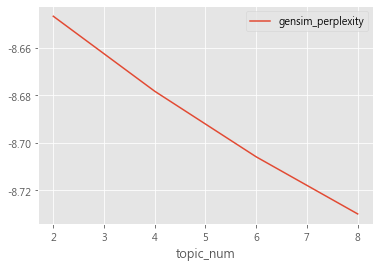

In [129]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
result

,topic_num,gensim_perplexity,perplexity
0,2,-8.646674,5691.188836
1,4,-8.678243,5873.716766
2,6,-8.705841,6038.075079
3,8,-8.729863,6184.880527


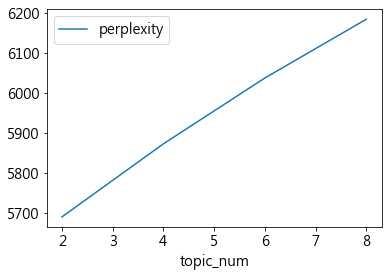

In [26]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

**4.5 視覺化呈現**

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 四個主題數，因此有四個圈圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

以下用主題數 4 來做 LDAvis 的結果範例，較方便解釋

In [27]:
#生成模型 
ldamodel2 = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus, 
    id2word=id2word, # 字典
    num_topics=4, # 生成幾個主題數
    random_state=2500, # 亂數
    iterations = 2000,
    passes=5, # 模型訓練次數
)
# 1分鐘內跑完

In [28]:
ldaVis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary=ldamodel.id2word)
pyLDAvis.save_html(ldaVis,'./lda_result/ldaVis.html')

**4.5.1 查看 Document 主題時間上分佈**

使用模型分析我們的資料，取得每條新聞的主題分佈，選最大的設為此文章的主題。<br>
再根據時間來做分析，了解不同的時間點討論的主題大多為什麽，以比例的方式呈現。

In [29]:
# 取得每條新聞的主題分佈
topics_doc = ldamodel.get_document_topics(corpus)  

# 將結果列成list
doc_list = []

# topics_doc[i] 為第一個文章
for i in range(0,len(topics_doc)):

    # 都先假定第一個主題為最大的
    max_freq = topics_doc[i][0][1]
    max_topic = topics_doc[i][0][0]

    # 後面假如有比較大的就取代
    for j in topics_doc[i]:
        if(j[1] > max_freq):
            max_freq = j[1]
            max_topic = j[0]

    doc_list.append(max_topic)

In [30]:
# 將結果放進 DataFrame裏
metadata['topic'] = doc_list

In [31]:
# 將 artDate 轉換為 Python 日期時間
metadata.artDate = pd.to_datetime(metadata['artDate'])

In [32]:
# groupby 日期、主題並計算文章篇數
date_topic = pd.DataFrame({
    'count':metadata.groupby(['artDate','topic']).size()
})

date_topic = date_topic.reset_index()
# date_topic.artDate.dt.to_period('M')：把日期按月份形式表示
date_topic = date_topic.groupby([date_topic.artDate.dt.to_period('M'),'topic']).sum().reset_index()


In [33]:
date_df = date_topic.pivot_table(index='artDate', values='count', columns='topic').fillna(0).reset_index()
date_df.columns = ['artDate', 'topic0', 'topic1', 'topic2', 'topic3']
# 前面日期變period形式要把他變回timestamp形式 --> to_timestamp：以便於畫圖
date_df = date_df.set_index('artDate').to_timestamp()
date_df

,topic0,topic1,topic2,topic3
artDate,,,,
2021-11-01,24,27,41,58
2021-12-01,125,227,283,215


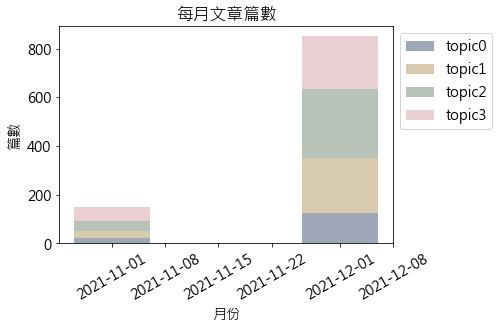

In [34]:
color = ["#9FA8B9", "#D8CAAF", "#B7C2B8", "#EAD0D5"]
column = ['topic0', 'topic1', 'topic2', 'topic3']
temp_bottom = 0

for i in range(0,4):
    if(i>0):
        temp_bottom = temp_bottom + date_df[column[i-1]]
        plt.bar(date_df.index, date_df[column[i]] ,color=color[i], bottom=temp_bottom ,label=column[i] , width=10)
    else: # 主題一 bottom 為 0
        plt.bar(date_df.index, date_df[column[i]] ,color=color[i], label=column[i] , width=10)
        

plt.title('每月文章篇數') # 標題
plt.xlabel('月份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置
plt.show()

我們也可以將它轉換為比例來看。

In [35]:
ratio_df = date_df.copy()
ratio_df['sum'] = ratio_df.topic0 + ratio_df.topic1 + ratio_df.topic2 + ratio_df.topic3

for i in range(0,4):
    ratio_df['topic'+str(i)] = ratio_df['topic'+str(i)] / ratio_df['sum']

ratio_df

,topic0,topic1,topic2,topic3,sum
artDate,,,,,
2021-11-01,0.160000,0.180000,0.273333,0.386667,150
2021-12-01,0.147059,0.267059,0.332941,0.252941,850


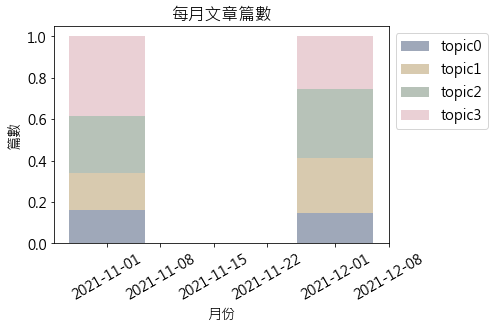

In [36]:
temp_bottom = 0

for i in range(0,4):
    if(i>0):
        temp_bottom = temp_bottom + ratio_df[column[i-1]]
        plt.bar(ratio_df.index, ratio_df[column[i]] ,color=color[i], bottom=temp_bottom ,label=column[i], width=10)
    else: # 主題一 bottom 為 0
        plt.bar(ratio_df.index, ratio_df[column[i]] ,color=color[i], label=column[i], width=10)

plt.title('每月文章篇數') # 標題
plt.xlabel('月份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置
plt.show()

可以根據上面的圖表，搭配時事推估，例如：
+ topic0 幾乎沒什麼改變，文章的數量都都屬於較少的。
+ topic1 11月時較少，後來有增多的趨向。
+ topic2 12月與11月相較之下，12月略多一些。
+ topic3 一開始討論度較高，文章篇數多，後期則慢慢減少。

In [37]:
## 主題一
metadata[metadata['topic'] == 0].sample(n=5)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,topic
23,Re:[新聞]林秉樞自稱有精神疾病王世堅:不修法等於,2021-12-02,15:08:13,https://www.ptt.cc/bbs/Gossiping/M.1638457695....,sex8088,Gossiping,2,2,0,"應該修法沒有精神病犯同樣罪,,也比照林秉樞規格處理才對,,台灣問題是媒體不鬧大或不是名人,,...",0
579,Re:[新聞]【獨家】【高嘉瑜遭家暴】遭新男友痛毆、,2021-11-30,01:32:03,https://www.ptt.cc/bbs/Gossiping/M.1638235925....,GreenBeret,Gossiping,63,12,11,"說坦白的 明顯是高大嬸的錯,,都,歲了 還跟前男友傳訊息,,說實在ㄉ 如果是你們看到女友傳訊...",0
297,Re:[新聞]林秉樞承認一時衝動打人宣稱「高嘉瑜也有還手」,2021-12-01,05:05:18,https://www.ptt.cc/bbs/Gossiping/M.1638335120....,yoyoflag,Gossiping,14,5,0,"這人是讀法律的 難怪會說出這種話來為自己辯護.....,,,台灣法官看到兩人互打,會說：,,...",0
749,Re:[新聞]網酸高嘉瑜為何不求助王婉諭直指：你們,2021-12-01,07:21:03,https://www.ptt.cc/bbs/Gossiping/M.1638343265....,neil136,Gossiping,8,0,0,"臺灣的政客以後參選可以驗,、,嗎,怎麼每個都號稱高學歷,結果做的事都比低能兒還智障,幹，特殊...",0
935,Re:[問卦]台灣犯什麼錯才會社會死亡？,2021-12-01,13:48:35,https://www.ptt.cc/bbs/Gossiping/M.1638366517....,protoss,Gossiping,2,1,0,"恰恰相反...,, 正因為膽小無良才會有最近這堆新聞...,, 生活中各種推拖擺...",0


In [38]:
## 主題二
metadata[metadata['topic'] == 1].sample(n=5)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,topic
556,[新聞]沒品維尼PTT黑了刑警害揹鍋調職 警友抱,2021-12-03,09:17:17,https://www.ptt.cc/bbs/Gossiping/M.1638523040....,dingwk,Gossiping,34,9,9,",,,.:,新聞雲 > 社會,,.:記者林悅／台南報導,,.:,沒品維尼,黑了刑警害揹鍋調...",1
540,Re:[新聞]高嘉瑜認了遭握｢親密影片｣全身傷不敢報,2021-11-30,01:22:23,https://www.ptt.cc/bbs/Gossiping/M.1638235346....,devidevi,Gossiping,9,4,0,"接下來會不會就是高嘉瑜已經被中共吸收,變成中共同路人,讓我們一起譴責高嘉瑜,讓高嘉瑜消失在台...",1
532,[問卦]合理懷疑林秉樞是大咖網軍,2021-12-01,04:36:22,https://www.ptt.cc/bbs/Gossiping/M.1638333384....,hellogym,Gossiping,525,305,27,"大家自己想想，林男,歲還在念博士,,一個堂堂立委，會這麼容易智障和這種咖交往嗎??,,所以要...",1
176,Re:[爆卦]國發會IP匿名用戶修改wiki林秉樞詞條被抓,2021-12-05,13:58:25,https://www.ptt.cc/bbs/Gossiping/M.1638712707....,snakei14702,Gossiping,15,9,0,"現在國發會說是交通部用這個,,,這什麼時代了,,文組的也知道跟,調一個,,,就可以知道是哪台...",1
133,Re:[新聞]綠名嘴：林秉樞有計畫滲透本土陣營涉國,2021-12-03,03:58:03,https://www.ptt.cc/bbs/Gossiping/M.1638503885....,gn02118620,Gossiping,3,1,0,",比較好奇的是曲棍球的態度吧,,這一年前的影片現在事後來看明顯是曲棍球在說高嘉瑜男朋友林秉樞...",1


In [39]:
## 主題三
metadata[metadata['topic'] == 2].sample(n=5)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,topic
871,[問卦]現在有風向說林秉樞背後是中國勢力!?,2021-12-03,05:01:20,https://www.ptt.cc/bbs/Gossiping/M.1638507682....,ycc0923202,Gossiping,16,2,4,"網軍頭子自爆這麼久，除了被切割,,開始有人在影射林秉樞背後有中國勢力，某媒體這樣說,,,「林...",2
668,Re:[新聞]高嘉瑜遭施暴1450出動？ 前男友「小馬」,2021-12-01,12:44:32,https://www.ptt.cc/bbs/Gossiping/M.1638362674....,zalora,Gossiping,210,38,46,"而,繫,，?,作,,,,有很多人覺得這帳號應該是綠營的網軍,,問題是他之前發的文章都在攻擊綠...",2
807,Re:[新聞]高嘉瑜遭暴打…扯出網軍帶風向何志偉怒,2021-12-03,03:47:16,https://www.ptt.cc/bbs/Gossiping/M.1638503238....,kinki999,Gossiping,6,1,0,"笑死，綠蟑螂網軍來亂～要關掉,,那中國去臉書瑞典教授假消息，是不是要關掉臉書時,,看到這影片...",2
879,Re:[新聞]高嘉瑜遭暴打…扯出網軍帶風向何志偉怒,2021-12-03,05:07:12,https://www.ptt.cc/bbs/Gossiping/M.1638508034....,goldsingle,Gossiping,417,297,10,"公子爺,,您不認秉樞了嗎,,您忘了大明湖畔的林秉樞了嗎,,,秉樞,,你瞬間就被拋棄了耶,,我...",2
975,[新聞]段宜康稱跟林秉樞不熟馬文鈺：段被林錄,2021-12-04,08:43:31,https://www.ptt.cc/bbs/Gossiping/M.1638607414....,k721102,Gossiping,483,239,13,"段宜康稱跟林秉樞不熟 馬文鈺：段被林錄了很多音,〔記者簡惠茹／台北報導〕民進黨立委高嘉瑜遭林...",2


In [40]:
## 主題四
metadata[metadata['topic'] == 3].sample(n=5)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,topic
614,[新聞]快訊／高嘉瑜遭逼供片送新北檢 律師11:3,2021-12-06,02:03:47,https://www.ptt.cc/bbs/Gossiping/M.1638756230....,DoraGmon,Gossiping,186,100,5,",.:,三立,,,.:,李依璇,,,.:,快訊／高嘉瑜遭逼供片送新北檢 律師,:,出面說明,...",3
514,Re:[新聞]林秉樞「月花5萬」包飯店 被逮嗆出呂秋,2021-12-01,04:16:34,https://www.ptt.cc/bbs/Gossiping/M.1638332196....,krajicek,Gossiping,52,26,0,"他財力到底多雄厚啊，一個月花五萬住飯店，租個房子都不用五萬啊,,這樣一年要花,萬飯店錢耶，之...",3
798,[新聞]抓到了！林秉樞手機性愛照曝光「至少4女,2021-12-01,11:55:53,https://www.ptt.cc/bbs/Gossiping/M.1638359756....,z753951zxc,Gossiping,112,56,12,"抓到了！林秉樞手機性愛照曝光「至少,女被拍」 反咬高嘉瑜：她有還手,,蘋果,,「港湖女神」高...",3
872,Re:[新聞]張忠謀赴司法院演講證實林秉樞與張淑芬,2021-12-06,07:15:12,https://www.ptt.cc/bbs/Gossiping/M.1638774914....,AZTEC,Gossiping,9,4,0,"之前民眾黨一直被笑,,都是些老藍男加入,,綠的都走光了,,現在看看拳哥,,就知道綠的有位置,...",3
577,[問卦]林秉樞大學高中讀哪裡？,2021-12-01,17:30:55,https://www.ptt.cc/bbs/Gossiping/M.1638379859....,william2001,Gossiping,94,45,3,"新聞只有說大學是讀法律系，,是哪一間的法律系？,也是政大法律的嗎？,新聞只提到政大博中央法碩...",3


## 5. 基本圖學

本週課程為 **基本圖學** ，主要會介紹圖的定義、性質，以及如何用套件呈現網絡圖。<br>
網絡圖有許多可以應用的情境，許多牽扯到「關聯」、「關係」都可以使用圖的方式來表達，像是：社交網路平台的好友關係、動物演生的關係、文章提到人物的關係...等。<br>
而本 jupyter notebook 使用 pyvis 來建立三國演義中人物的人物關係圖，並進一步進行操作、分析。

In [41]:
MetaData = pd.read_csv('./raw_data/高嘉瑜_articleMetaData.csv', encoding='UTF-8')
print(f"共有 {MetaData.shape[0]} 篇文章") #(row,column)
MetaData.head(3)

共有 1539 篇文章


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[問卦]高嘉瑜遭家暴？新男友痛毆控制行動？,2021/11/29,23:07:53,https://www.ptt.cc/bbs/Gossiping/M.1638227275....,godofsex,Gossiping,373,217,33,https://www.mirrormedia.mg/story/20211127inv00...
1,Re:[爆卦]高嘉瑜遭家暴？新男友痛毆控制行動,2021/11/29,23:19:58,https://www.ptt.cc/bbs/Gossiping/M.1638228000....,ivorysoap,Gossiping,24,13,1,如果是真的\n\n希望可以看到DPP的婦女部發聲明遣責渣男啊\n\n這也證明了鄉民的名言\n...
2,[新聞]高嘉瑜驚傳遭現任男友痛毆、控制行動！,2021/11/29,23:45:49,https://www.ptt.cc/bbs/Gossiping/M.1638229551....,DDDDRR,Gossiping,626,338,48,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:新頭殼\n2.記者署名:|張柏源 綜合...


In [42]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
#新增自定義字典
jieba.load_userdict('./dict/user_dict.txt')
#新增stop words
#jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from C:\Users\ASUS\jupyter\第三次讀書會\dict\dict.txt.big ...
Loading model from cache C:\Users\ASUS\AppData\Local\Temp\jieba.ub16e643c62158fd13bdbd4875d2ffb0a.cache
Loading model cost 1.366 seconds.
Prefix dict has been built successfully.


In [43]:
def getToken(row):    
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w) > 1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [44]:
MetaData['sentence'] = pd.DataFrame(MetaData['sentence'].astype(str))

In [45]:
# 匯入人物檔案
names = []

with open(f'./dict/name.txt','r', encoding='UTF-8') as f:
    names = f.read().splitlines() #移除換行符號\n

In [46]:
word_df = MetaData.assign(word = MetaData['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)
word_df

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,word
0,[問卦]高嘉瑜遭家暴？新男友痛毆控制行動？,2021/11/29,23:07:53,https://www.ptt.cc/bbs/Gossiping/M.1638227275....,godofsex,Gossiping,373,217,33,https
0,[問卦]高嘉瑜遭家暴？新男友痛毆控制行動？,2021/11/29,23:07:53,https://www.ptt.cc/bbs/Gossiping/M.1638227275....,godofsex,Gossiping,373,217,33,:
0,[問卦]高嘉瑜遭家暴？新男友痛毆控制行動？,2021/11/29,23:07:53,https://www.ptt.cc/bbs/Gossiping/M.1638227275....,godofsex,Gossiping,373,217,33,/
0,[問卦]高嘉瑜遭家暴？新男友痛毆控制行動？,2021/11/29,23:07:53,https://www.ptt.cc/bbs/Gossiping/M.1638227275....,godofsex,Gossiping,373,217,33,/
0,[問卦]高嘉瑜遭家暴？新男友痛毆控制行動？,2021/11/29,23:07:53,https://www.ptt.cc/bbs/Gossiping/M.1638227275....,godofsex,Gossiping,373,217,33,www
...,...,...,...,...,...,...,...,...,...,...
1538,Re:[新聞]家暴案扯出網軍黑幕！高嘉瑜喊「好煩」：,2021/12/06,15:57:22,https://www.ptt.cc/bbs/Gossiping/M.1638806245....,ak47good,Gossiping,61,8,0,中國
1538,Re:[新聞]家暴案扯出網軍黑幕！高嘉瑜喊「好煩」：,2021/12/06,15:57:22,https://www.ptt.cc/bbs/Gossiping/M.1638806245....,ak47good,Gossiping,61,8,0,人嘛
1538,Re:[新聞]家暴案扯出網軍黑幕！高嘉瑜喊「好煩」：,2021/12/06,15:57:22,https://www.ptt.cc/bbs/Gossiping/M.1638806245....,ak47good,Gossiping,61,8,0,…
1538,Re:[新聞]家暴案扯出網軍黑幕！高嘉瑜喊「好煩」：,2021/12/06,15:57:22,https://www.ptt.cc/bbs/Gossiping/M.1638806245....,ak47good,Gossiping,61,8,0,…


In [47]:
# 篩選有在人物名稱裡的
word_df = word_df[(word_df['word'].isin(names) == True)]
word_df

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,word
2,[新聞]高嘉瑜驚傳遭現任男友痛毆、控制行動！,2021/11/29,23:45:49,https://www.ptt.cc/bbs/Gossiping/M.1638229551....,DDDDRR,Gossiping,626,338,48,高嘉瑜
2,[新聞]高嘉瑜驚傳遭現任男友痛毆、控制行動！,2021/11/29,23:45:49,https://www.ptt.cc/bbs/Gossiping/M.1638229551....,DDDDRR,Gossiping,626,338,48,高嘉瑜
2,[新聞]高嘉瑜驚傳遭現任男友痛毆、控制行動！,2021/11/29,23:45:49,https://www.ptt.cc/bbs/Gossiping/M.1638229551....,DDDDRR,Gossiping,626,338,48,高嘉瑜
2,[新聞]高嘉瑜驚傳遭現任男友痛毆、控制行動！,2021/11/29,23:45:49,https://www.ptt.cc/bbs/Gossiping/M.1638229551....,DDDDRR,Gossiping,626,338,48,林秉樞
2,[新聞]高嘉瑜驚傳遭現任男友痛毆、控制行動！,2021/11/29,23:45:49,https://www.ptt.cc/bbs/Gossiping/M.1638229551....,DDDDRR,Gossiping,626,338,48,林秉樞
...,...,...,...,...,...,...,...,...,...,...
1536,[新聞]館長暖心送高嘉瑜「女孩必中」神物！,2021/12/06,15:02:16,https://www.ptt.cc/bbs/Gossiping/M.1638802938....,gginin007,Gossiping,27,12,5,林秉樞
1536,[新聞]館長暖心送高嘉瑜「女孩必中」神物！,2021/12/06,15:02:16,https://www.ptt.cc/bbs/Gossiping/M.1638802938....,gginin007,Gossiping,27,12,5,高嘉瑜
1536,[新聞]館長暖心送高嘉瑜「女孩必中」神物！,2021/12/06,15:02:16,https://www.ptt.cc/bbs/Gossiping/M.1638802938....,gginin007,Gossiping,27,12,5,林秉樞
1536,[新聞]館長暖心送高嘉瑜「女孩必中」神物！,2021/12/06,15:02:16,https://www.ptt.cc/bbs/Gossiping/M.1638802938....,gginin007,Gossiping,27,12,5,高嘉瑜


計算每個字在不同章節出現的次數

In [48]:
word_df = word_df.assign(count = 1)
word_token = word_df.groupby(['artTitle','word'])[['count']].sum().reset_index().sort_values('count', ascending=False)
word_token = word_token[ word_token['count'] > 1] #篩掉=1的
word_token

,artTitle,word,count
1534,[新聞]高嘉瑜前男友駁鬧靈堂 發聲明：窮盡所,林秉樞,44
1613,[新聞]高嘉瑜遭施暴 前男友還原「鬧靈堂」真,林秉樞,42
403,Re:[新聞]高嘉瑜：剛交往時就被逼下跪自責「覺得,高嘉瑜,38
19,Re:[問卦]塔綠班宇宙之網軍地位考據,高嘉瑜,26
1376,[新聞]被指大鬧高嘉瑜現任男友亡母靈堂前男友,林秉樞,24
...,...,...,...
740,[新聞]「台獨機關槍」李柏璋曾被通緝竟涉偷拍,李男,2
1328,[新聞]綠營打手?林秉樞過往撰文被起底徐巧芯:,高嘉瑜,2
813,[新聞]台南重量級人士操作洗白陳亭妃：完全不認,李柏璋,2
193,Re:[新聞]暗黑網軍傷害台灣朱立倫喊話蔡英文脫下,小馬,2


In [49]:
word_pairs = word_token.copy()
perms = word_pairs.groupby('artTitle')['word'].apply(lambda s: pd.DataFrame(permutations(s, 2), columns=['term1', 'term2'])).reset_index()
perms = perms.drop('level_1', axis=1)
perms

,artTitle,term1,term2
0,Re:[問卦]塔綠班宇宙之網軍地位考據,高嘉瑜,林秉樞
1,Re:[問卦]塔綠班宇宙之網軍地位考據,高嘉瑜,前男友
2,Re:[問卦]塔綠班宇宙之網軍地位考據,高嘉瑜,馬文鈺
3,Re:[問卦]塔綠班宇宙之網軍地位考據,林秉樞,高嘉瑜
4,Re:[問卦]塔綠班宇宙之網軍地位考據,林秉樞,前男友
...,...,...,...
1839,[爆卦]高嘉瑜家暴事件沒說到的幕後花絮,高嘉瑜,前男友
1840,[爆卦]高嘉瑜家暴事件沒說到的幕後花絮,高嘉瑜,林男
1841,[爆卦]高嘉瑜家暴事件沒說到的幕後花絮,高嘉瑜,小馬
1842,[爆卦]高嘉瑜：他有我的不雅照包括跟前女友,林先生,高嘉瑜


In [50]:
word_pair = perms.copy()
word_pair['n'] = 1
word_pair = word_pair.groupby(['term1','term2'])[['n']].sum().reset_index()
word_pair = word_pair.sort_values('n', ascending=False).reset_index().drop('index', axis=1)
word_pair.head(10)

,term1,term2,n
0,高嘉瑜,林秉樞,216
1,林秉樞,高嘉瑜,216
2,林男,高嘉瑜,59
3,高嘉瑜,林男,59
4,馬文鈺,高嘉瑜,53
5,高嘉瑜,馬文鈺,53
6,林秉樞,馬文鈺,47
7,馬文鈺,林秉樞,47
8,林秉樞,林男,44
9,林男,林秉樞,44


移除重複的人物組合（term1 & term2）

In [51]:
word_pair = word_pair[word_pair.index % 2 == 1]
word_pair

,term1,term2,n
1,林秉樞,高嘉瑜,216
3,高嘉瑜,林男,59
5,高嘉瑜,馬文鈺,53
7,馬文鈺,林秉樞,47
9,林男,林秉樞,44
...,...,...,...
193,范雲,宣明智,1
195,小馬,范雲,1
197,詹宏志,李柏璋,1
199,小馬,宣明智,1


**2.4 計算人物間Correlation**
+ 斜對角(自己&自己)：correlation = 1
+ 上半部跟下半部會一樣

# 新增區段

In [52]:
artTitle_word = pd.crosstab(word_pairs.artTitle, word_pairs.word)
word_cor = artTitle_word.copy()
word_cor = word_cor.reset_index()
correlation = word_cor.corr(method='pearson')
correlation

word,+魚,前男友,加魚,吳女,吳姓,呱吉,宣明智,小馬,朱立倫,李柏璋,...,林男,林秉樞,柯文哲,王世堅,王浩宇,范雲,詹宏志,馬文鈺,高嘉瑜,黃覲偉
word,,,,,,,,,,,,,,,,,,,,,
+魚,1.000000,0.119368,-0.007852,-0.007262,-0.004175,-0.002949,-0.005119,-0.017821,-0.004175,-0.022253,...,-0.026444,-0.022313,-0.016367,-0.008404,-0.005119,-0.010770,-0.016367,-0.023218,-0.028306,-0.005119
前男友,0.119368,1.000000,0.042154,-0.028468,-0.016367,-0.011561,-0.020067,0.270930,-0.016367,-0.058863,...,0.095681,-0.004303,-0.064159,-0.032942,-0.020067,0.065508,-0.064159,0.293241,0.108362,-0.020067
加魚,-0.007852,0.042154,1.000000,-0.013658,-0.007852,-0.005547,-0.009627,0.169690,-0.007852,-0.041851,...,0.049320,-0.170529,-0.030781,-0.015804,-0.009627,-0.020254,-0.030781,0.010888,-0.148000,-0.009627
吳女,-0.007262,-0.028468,-0.013658,1.000000,0.574935,-0.005130,-0.008904,-0.030997,-0.007262,-0.038706,...,0.114319,0.040458,-0.028468,-0.014616,-0.008904,-0.018732,-0.028468,-0.040384,0.032567,-0.008904
吳姓,-0.004175,-0.016367,-0.007852,0.574935,1.000000,-0.002949,-0.005119,-0.017821,-0.004175,-0.022253,...,0.065726,0.046048,-0.016367,-0.008404,-0.005119,-0.010770,-0.016367,-0.023218,0.042239,-0.005119
呱吉,-0.002949,-0.011561,-0.005547,-0.005130,-0.002949,1.000000,-0.003616,-0.012588,-0.002949,-0.015719,...,-0.018679,0.032527,-0.011561,-0.005936,-0.003616,-0.007607,-0.011561,-0.016400,0.029836,-0.003616
宣明智,-0.005119,-0.020067,-0.009627,-0.008904,-0.005119,-0.003616,1.000000,0.081184,-0.005119,-0.027283,...,-0.032421,0.056456,-0.020067,-0.010303,-0.006276,0.149642,0.312764,0.220480,0.051786,-0.006276
小馬,-0.017821,0.270930,0.169690,-0.030997,-0.017821,-0.012588,0.081184,1.000000,-0.017821,0.036754,...,0.118543,-0.095236,0.032378,0.090987,-0.021849,0.004056,0.032378,0.206780,0.003167,-0.021849
朱立倫,-0.004175,-0.016367,-0.007852,-0.007262,-0.004175,-0.002949,-0.005119,-0.017821,1.000000,-0.022253,...,0.065726,0.046048,-0.016367,-0.008404,-0.005119,-0.010770,0.119368,-0.023218,-0.028306,-0.005119


In [53]:
correlation.index.name = 'term1'
correlation = correlation.reset_index()
tidy = pd.DataFrame()
tidy = pd.melt(correlation, id_vars='term1', var_name='term2', value_name='correlation')
tidy

,term1,term2,correlation
0,+魚,+魚,1.000000
1,前男友,+魚,0.119368
2,加魚,+魚,-0.007852
3,吳女,+魚,-0.007262
4,吳姓,+魚,-0.004175
...,...,...,...
671,范雲,黃覲偉,-0.013204
672,詹宏志,黃覲偉,-0.020067
673,馬文鈺,黃覲偉,-0.028466
674,高嘉瑜,黃覲偉,0.051786


移除自己跟自己的關聯

In [54]:
tidy = tidy.sort_values('correlation', ascending=False)
tidy = tidy[ tidy['term1'] != 'artTitle']
tidy = tidy[ tidy['term2'] != 'artTitle']
tidy = tidy[ tidy['term1'] != tidy['term2']] 
tidy

,term1,term2,correlation
82,吳姓,吳女,0.574935
107,吳女,吳姓,0.574935
578,宣明智,詹宏志,0.312764
178,詹宏志,宣明智,0.312764
279,王世堅,李男,0.307232
...,...,...,...
76,高嘉瑜,加魚,-0.148000
444,加魚,林秉樞,-0.170529
69,林秉樞,加魚,-0.170529
460,柯文哲,林秉樞,-0.207594


## 5.2 建立Network

**5.2.1 畫出人物關聯性社群網路圖**<br>

由於人物關係單純，所以我們只取correlation大於0

In [55]:
point_five = tidy[tidy['correlation']>0]
point_five.set_index = ('term1')
point_five

,term1,term2,correlation
82,吳姓,吳女,0.574935
107,吳女,吳姓,0.574935
578,宣明智,詹宏志,0.312764
178,詹宏志,宣明智,0.312764
279,王世堅,李男,0.307232
...,...,...,...
490,詹宏志,柯文哲,0.009231
203,范雲,小馬,0.004056
553,小馬,范雲,0.004056
206,高嘉瑜,小馬,0.003167


In [56]:
five_net = Network(height='750px', width='100%', bgcolor='#ffffff', font_color='black') #設定

sources = point_five['term1']
targets = point_five['term2']
weights = point_five['correlation']

edge_data = zip(sources, targets, weights)
for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]*10

    five_net.add_node(src, src, title=src)
    five_net.add_node(dst, dst, title=dst)
    five_net.add_edge(src, dst, value=w)

neighbor_map = five_net.get_adj_list()

for node in five_net.nodes:
    node['title'] += ' Neighbors:<br>' + '<br>'.join(neighbor_map[node['id']])
    node['value'] = len(neighbor_map[node['id']])

five_net.show('five_net.html')
# IPython.display.HTML(filename="./five_net.html")

<img src="./image/關係圖.jpg" style="float:left;" width="500px;">  

## 6. 社群網路分析校正回歸事件

會先透過LDA為資料進行主題分析，再以不同角度對社群進行篩選，進行網路分析。

In [57]:
#匯入留言資料
Reviews = pd.read_csv('./raw_data/高嘉瑜_articleReviews.csv', encoding='UTF-8')

In [58]:
MetaData.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[問卦]高嘉瑜遭家暴？新男友痛毆控制行動？,2021/11/29,23:07:53,https://www.ptt.cc/bbs/Gossiping/M.1638227275....,godofsex,Gossiping,373,217,33,https://www.mirrormedia.mg/story/20211127inv00...
1,Re:[爆卦]高嘉瑜遭家暴？新男友痛毆控制行動,2021/11/29,23:19:58,https://www.ptt.cc/bbs/Gossiping/M.1638228000....,ivorysoap,Gossiping,24,13,1,如果是真的\n\n希望可以看到DPP的婦女部發聲明遣責渣男啊\n\n這也證明了鄉民的名言\n...
2,[新聞]高嘉瑜驚傳遭現任男友痛毆、控制行動！,2021/11/29,23:45:49,https://www.ptt.cc/bbs/Gossiping/M.1638229551....,DDDDRR,Gossiping,626,338,48,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:新頭殼\n2.記者署名:|張柏源 綜合...


In [59]:
Reviews.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,cmtPoster,cmtStatus,cmtDate,cmtContent
0,[問卦]高嘉瑜遭家暴？新男友痛毆控制行動？,2021/11/29,23:07:53,https://www.ptt.cc/bbs/Gossiping/M.1638227275....,godofsex,Gossiping,cs09312,噓,2021-11-30 07:08:00,:掰
1,[問卦]高嘉瑜遭家暴？新男友痛毆控制行動？,2021/11/29,23:07:53,https://www.ptt.cc/bbs/Gossiping/M.1638227275....,godofsex,Gossiping,kiki1219,推,2021-11-30 07:08:00,:樓下點
2,[問卦]高嘉瑜遭家暴？新男友痛毆控制行動？,2021/11/29,23:07:53,https://www.ptt.cc/bbs/Gossiping/M.1638227275....,godofsex,Gossiping,s8800892000,推,2021-11-30 07:08:00,:算


In [60]:
# 合併每篇文章對應的留言
Reviews = MetaData.iloc[:,0:-1].merge(Reviews.loc[:,["artUrl", "cmtContent", "cmtPoster", "cmtStatus", "cmtContent"]], how = "left", on = 'artUrl')

In [61]:
print(Reviews.shape)
Reviews.head(3)

(144843, 13)


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent,cmtPoster,cmtStatus,cmtContent
0,[問卦]高嘉瑜遭家暴？新男友痛毆控制行動？,2021/11/29,23:07:53,https://www.ptt.cc/bbs/Gossiping/M.1638227275....,godofsex,Gossiping,373,217,33,:掰,cs09312,噓,:掰
1,[問卦]高嘉瑜遭家暴？新男友痛毆控制行動？,2021/11/29,23:07:53,https://www.ptt.cc/bbs/Gossiping/M.1638227275....,godofsex,Gossiping,373,217,33,:樓下點,kiki1219,推,:樓下點
2,[問卦]高嘉瑜遭家暴？新男友痛毆控制行動？,2021/11/29,23:07:53,https://www.ptt.cc/bbs/Gossiping/M.1638227275....,godofsex,Gossiping,373,217,33,:算,s8800892000,推,:算


In [62]:
#移除PTT貼新聞時會出現的格式用字
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(媒體來源|記者署名|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除)', '', str(x)))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(http|https)://.*', '', x))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('\n', ',', x))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('[a-zA-Z0-9]+', ',', x))

In [63]:
#整理Reviews格式
# Reviews['cmtContent'] = Reviews.cmtContent.apply(lambda x: re.sub(':', '', str(x)))
# Reviews['cmtContent'] = Reviews.cmtContent.apply(lambda x: re.sub('\n', ',', x))
# Reviews['cmtContent'] = Reviews.cmtContent.apply(lambda x: re.sub('[a-zA-Z0-9]+', ',', x))

In [64]:
data = MetaData.copy()
data['word'] = data.sentence.apply(getToken)

In [65]:
data.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,[問卦]高嘉瑜遭家暴？新男友痛毆控制行動？,2021/11/29,23:07:53,https://www.ptt.cc/bbs/Gossiping/M.1638227275....,godofsex,Gossiping,373,217,33,",,這是真的假的啊？,,港湖女神耶？這樣還會被家暴？,,太慘了吧！,,（這樣算政問嗎？求解）...","[真的假, 港湖, 女神, 家暴, 太慘, 算政問, 求解, 子有, 三十個, 可怕, 感覺]"
1,Re:[爆卦]高嘉瑜遭家暴？新男友痛毆控制行動,2021/11/29,23:19:58,https://www.ptt.cc/bbs/Gossiping/M.1638228000....,ivorysoap,Gossiping,24,13,1,"如果是真的,,希望可以看到,的婦女部發聲明遣責渣男啊,,這也證明了鄉民的名言,,每一個女神背...","[希望, 看到, 婦女部, 發聲明, 遣責渣, 這也, 證明, 鄉民, 名言, 女神, 背後..."
2,[新聞]高嘉瑜驚傳遭現任男友痛毆、控制行動！,2021/11/29,23:45:49,https://www.ptt.cc/bbs/Gossiping/M.1638229551....,DDDDRR,Gossiping,626,338,48,",,,.:新頭殼,,.:|張柏源 綜合報導,,.:高嘉瑜驚傳遭現任男友痛毆、控制行動！ 周...","[頭殼, 張柏源, 綜合, 報導, 高嘉瑜, 驚傳, 現任, 男友, 痛毆, 控制, 行動,..."


## 6.2. LDA

### 6.2.1 LDA資料準備
- 將斷詞結果轉成list型式，使用id2word 將斷詞結果生成字典

In [66]:
token_data = data['word'].tolist()

In [67]:
id2word = corpora.Dictionary(token_data)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(20936 unique tokens: ['三十個', '可怕', '太慘', '女神', '子有']...)


- 將斷詞結果建構語料庫(corpus)，利用語料庫把每篇文章數字化。  
- 每篇文章、每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。

In [68]:
corpus = [id2word.doc2bow(text) for text in token_data]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


### 6.2.2 建立LDA

In [69]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus,  # 文檔語料庫
    id2word=id2word, # 詞彙字典
    num_topics=3, # 生成幾個主題數
    random_state=1205, # 亂數
    iterations = 1000, # 每個文章訓練的次數，可以設定高一點讓模型收斂
    passes=5, # 模型訓練次數
)

### 6.2.3 判斷每筆發文的主題
**查看 LDA 各主題代表字**  
- 查看每個主題的單詞分佈

In [70]:
# 每個主題重要的前25個關鍵字
topics = ldamodel.print_topics(num_words=25)
for topic in topics:
    print(topic)
    print("")

(0, '0.022*"林秉樞" + 0.021*"高嘉瑜" + 0.010*"民進黨" + 0.009*"立委" + 0.005*"男友" + 0.005*"家暴" + 0.004*"林男" + 0.004*"知道" + 0.004*"表示" + 0.004*"報導" + 0.004*"媒體" + 0.003*"影片" + 0.003*"李柏璋" + 0.003*"事件" + 0.003*"現在" + 0.003*"風向" + 0.003*"施暴" + 0.003*"飯店" + 0.003*"政治" + 0.003*"馬文鈺" + 0.003*"新聞" + 0.003*"認識" + 0.003*"台灣" + 0.003*"記者" + 0.002*"網軍"')

(1, '0.009*"林秉樞" + 0.005*"立委" + 0.003*"現在" + 0.003*"高嘉瑜" + 0.003*"林男" + 0.003*"知道" + 0.003*"家暴" + 0.003*"媒體" + 0.003*"詹宏志" + 0.003*"造謠" + 0.003*"飯店" + 0.002*"事情" + 0.002*"記者" + 0.002*"民進黨" + 0.002*"下跪" + 0.002*"新聞" + 0.002*"新潮流" + 0.002*"檢舉" + 0.002*"網軍" + 0.002*"恐嚇" + 0.002*"保護" + 0.002*"表示" + 0.002*"董事長" + 0.002*"最後" + 0.002*"報導"')

(2, '0.009*"高嘉瑜" + 0.005*"林秉樞" + 0.004*"家暴" + 0.004*"知道" + 0.004*"台灣" + 0.003*"現在" + 0.003*"立委" + 0.003*"新聞" + 0.003*"私密" + 0.003*"民進黨" + 0.003*"被害人" + 0.002*"事件" + 0.002*"影片" + 0.002*"暴力" + 0.002*"問題" + 0.002*"影像" + 0.002*"事情" + 0.002*"范雲" + 0.002*"表示" + 0.002*"社會" + 0.002*"飯店" + 0.002*"看到" + 0.002*"處理" + 0.001*"八卦" + 0.001*

**可以歸納出**
- topic 0 = “林秉樞高嘉瑜與民進黨間的關係”
- topic 1 = “林秉樞恐嚇高嘉瑜的關係”
- topic 2 = “林秉樞家暴對高嘉瑜的關係”  

<b><mark><font color=red>*以下我們挑出 第零個主題 與 第二個主題 來做比較。 </font></mark></b>   

**以每筆發文的"主題分佈"中分數最大的主題當作該文章的主題**

In [71]:
# 取得每筆發文的主題分佈
topics_doc = ldamodel.get_document_topics(corpus,minimum_probability=0)

# 把每筆發文的主題分佈存成list
probabilities = [ [entry[1] for entry in doc] for doc in topics_doc ]
print(probabilities[0:3])

# 找出probabilities最大的主題 存入 doc_list
doc_list = [np.argmax(t) for t in probabilities]

[[0.14353262, 0.030522615, 0.8259447], [0.7622807, 0.2145204, 0.023198897], [0.9975694, 0.0012142989, 0.001216368]]


In [72]:
# 將結果放進 DataFrame裏
data['topic'] = doc_list

In [73]:
data[["artTitle","topic"]].head(5)

,artTitle,topic
0,[問卦]高嘉瑜遭家暴？新男友痛毆控制行動？,2
1,Re:[爆卦]高嘉瑜遭家暴？新男友痛毆控制行動,0
2,[新聞]高嘉瑜驚傳遭現任男友痛毆、控制行動！,0
3,[新聞]高嘉瑜傳遭男友家暴 疑「親密影片」被,0
4,Re:[新聞]高嘉瑜驚傳遭現任男友痛毆、控制行動！,0


### 6.2.4 資料內容探索
**查看兩個主題的內容**

In [74]:
data[(data["topic"]==0)&(data["artTitle"].str.contains("高嘉瑜"))][["artTitle","topic"]].sample(n=5)

,artTitle,topic
272,[新聞]新女友？高嘉瑜男友飯店被捕1長髮女陪伴,0
856,Re:[新聞]高嘉瑜遭暴打…扯出網軍帶風向何志偉怒,0
1505,Re:[新聞]家暴案扯出網軍黑幕！高嘉瑜喊「好煩」：,0
197,Re:[新聞]高嘉瑜男友太渣！啃老為錢囚禁老母逼下,0
256,Re:[爆卦]馬文鈺喪禮鬧場高嘉瑜本人報警抓人,0


In [75]:
data[(data["topic"]==2)&(data["artTitle"].str.contains("高嘉瑜"))][["artTitle","topic"]].sample(n=5)

,artTitle,topic
1043,[新聞]挺高嘉瑜「被害人沒有錯」范雲籲設專法,2
30,Re:[新聞]高嘉瑜傳遭男友家暴 疑「親密影片」被,2
137,Re:[爆卦]高嘉瑜家暴事件沒說到的幕後花絮,2
187,Re:[新聞]被爆痛揍高嘉瑜林秉樞過往評論曝光：嗆,2
384,Re:[新聞]網酸高嘉瑜為何不求助王婉諭直指：你們,2


**畫出每日主題分布**

In [76]:
# 轉換artDate為 Python 日期格式
data['artDate'] = pd.to_datetime(data['artDate'], format="%Y-%m-%d")

In [77]:
# groupby 日期、主題並計算文章篇數
date_topic = pd.DataFrame({
    'count':data.groupby(['artDate','topic']).size()
})

date_topic = date_topic.reset_index()
date_topic

,artDate,topic,count
0,2021-11-29,0,2
1,2021-11-29,2,1
2,2021-11-30,0,128
3,2021-11-30,1,48
4,2021-11-30,2,49
5,2021-12-01,0,175
6,2021-12-01,1,73
7,2021-12-01,2,52
8,2021-12-02,0,137
9,2021-12-02,1,57


In [78]:
date_df = date_topic.pivot_table(index='artDate', values='count', columns='topic').fillna(0).reset_index()
date_df.columns = ['artDate', 'topic0', 'topic1', 'topic2']
date_df = date_df.set_index('artDate')
date_df

,topic0,topic1,topic2
artDate,,,
2021-11-29,2.0,0.0,1.0
2021-11-30,128.0,48.0,49.0
2021-12-01,175.0,73.0,52.0
2021-12-02,137.0,57.0,51.0
2021-12-03,139.0,52.0,51.0
2021-12-04,91.0,51.0,28.0
2021-12-05,103.0,74.0,52.0
2021-12-06,59.0,41.0,25.0


**查看每天發文數量**

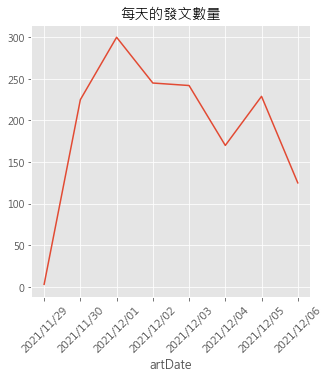

In [124]:
data_datecount = pd.DataFrame(MetaData.groupby('artDate').size(),columns = ['count'])

plt.figure(figsize=(5,5))   # 顯示圖框架大小 (寬,高)
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  #使中文能正常顯示
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.title('每天的發文數量')
plt.xlabel('artDate')
plt.xticks(rotation= 45, fontsize=11)
plt.plot(data_datecount.index,data_datecount['count'].tolist())

In [80]:
date_df["topic0"]

artDate
2021-11-29      2.0
2021-11-30    128.0
2021-12-01    175.0
2021-12-02    137.0
2021-12-03    139.0
2021-12-04     91.0
2021-12-05    103.0
2021-12-06     59.0
Name: topic0, dtype: float64

In [81]:
data_date = data.groupby(['artDate'],as_index=False).size()
data_date_r = data_date.assign(ratio = data_date.groupby(['artDate'], as_index=False))
data_date_r['artDate'] = pd.to_datetime(data_date_r['artDate'], format="%Y/%m/%d")

C:\Users\ASUS\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [82]:
data_date_r

,artDate,size,ratio
0,2021-11-29,3,"(2021-11-29 00:00:00, [artDate])"
1,2021-11-30,225,"(2021-11-30 00:00:00, [artDate])"
2,2021-12-01,300,"(2021-12-01 00:00:00, [artDate])"
3,2021-12-02,245,"(2021-12-02 00:00:00, [artDate])"
4,2021-12-03,242,"(2021-12-03 00:00:00, [artDate])"
5,2021-12-04,170,"(2021-12-04 00:00:00, [artDate])"
6,2021-12-05,229,"(2021-12-05 00:00:00, [artDate])"
7,2021-12-06,125,"(2021-12-06 00:00:00, [artDate])"


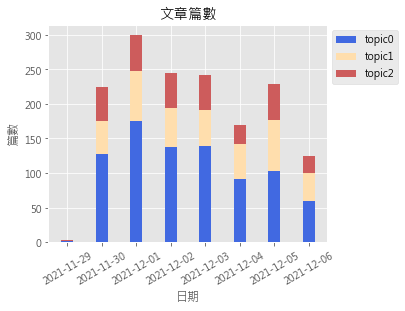

In [126]:
plt.figure(figsize=(5,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
ind = np.arange(8)
width = 0.35     

plt.bar(ind, np.array(date_df["topic0"]), width, label="topic0",color='royalblue')
plt.bar(ind, np.array(date_df["topic1"]), width,  bottom=date_df["topic0"], label="topic1",color='navajowhite')
plt.bar(ind, np.array(date_df["topic2"]), width,  bottom=date_df["topic0"]+date_df["topic1"], label="topic2",color='indianred')

#plt.xticks(ind,data_date_r['artDate'])
plt.xticks(ind,('2021-11-29','2021-11-30', '2021-12-01', '2021-12-02','2021-12-03', '2021-12-04', '2021-12-05','2021-12-06'))
plt.title('文章篇數') # 標題
plt.xlabel('日期') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置
plt.show()

### 6.3 社群網路圖
社群網絡分析就是運用圖論(Graph theory)從這些節點和連結去研究人與人之間的關係以及整個群體的結構。

### 6.4 基本網路圖

In [84]:
# 把reviews中 cmtPoster(回覆者), cmtStatus(推噓), cmtContent(留言) 合併到 data的資料表
posts_Reviews = Reviews.loc[:,["artUrl", "cmtPoster", "cmtStatus", "cmtContent"]]
posts_Reviews  = pd.merge(data, posts_Reviews, how="right", on="artUrl")
posts_Reviews = posts_Reviews[posts_Reviews["commentNum"]>0]

In [85]:
posts_Reviews.head(2)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word,topic,cmtPoster,cmtStatus,cmtContent,cmtContent
0,[問卦]高嘉瑜遭家暴？新男友痛毆控制行動？,2021-11-29,23:07:53,https://www.ptt.cc/bbs/Gossiping/M.1638227275....,godofsex,Gossiping,373,217,33,",,這是真的假的啊？,,港湖女神耶？這樣還會被家暴？,,太慘了吧！,,（這樣算政問嗎？求解）...","[真的假, 港湖, 女神, 家暴, 太慘, 算政問, 求解, 子有, 三十個, 可怕, 感覺]",2,cs09312,噓,:掰,:掰
1,[問卦]高嘉瑜遭家暴？新男友痛毆控制行動？,2021-11-29,23:07:53,https://www.ptt.cc/bbs/Gossiping/M.1638227275....,godofsex,Gossiping,373,217,33,",,這是真的假的啊？,,港湖女神耶？這樣還會被家暴？,,太慘了吧！,,（這樣算政問嗎？求解）...","[真的假, 港湖, 女神, 家暴, 太慘, 算政問, 求解, 子有, 三十個, 可怕, 感覺]",2,kiki1219,推,:樓下點,:樓下點


In [86]:
# 取出 cmtPoster(回覆者)、artPoster(發文者)、artUrl(文章連結) 三個欄位
link = posts_Reviews.loc[:,["cmtPoster", "artPoster", "artUrl"]]
link.head(5)

,cmtPoster,artPoster,artUrl
0,cs09312,godofsex,https://www.ptt.cc/bbs/Gossiping/M.1638227275....
1,kiki1219,godofsex,https://www.ptt.cc/bbs/Gossiping/M.1638227275....
2,s8800892000,godofsex,https://www.ptt.cc/bbs/Gossiping/M.1638227275....
3,s8800892000,godofsex,https://www.ptt.cc/bbs/Gossiping/M.1638227275....
4,snow3804,godofsex,https://www.ptt.cc/bbs/Gossiping/M.1638227275....


In [87]:
len(link)

144831

使用 cmtPoster(回覆者)、artPoster(發文者) 建立兩者的連結，這裡先嘗試使用前100筆資料(總共有206605筆資料)

In [88]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for i in range(0,100):
    G.add_edge(link["cmtPoster"][i], link["artPoster"][i])
    

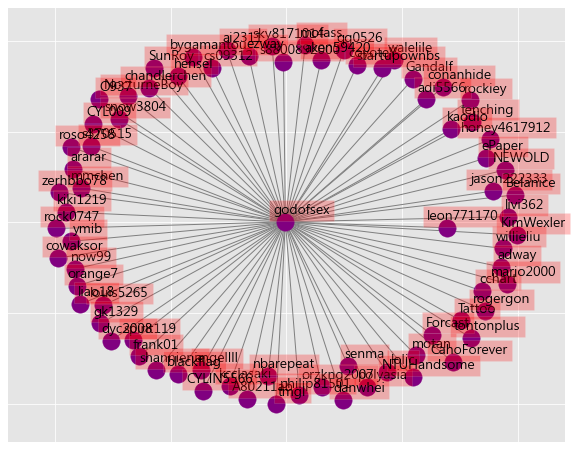

In [89]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
#                  width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045 #調整label的位置(右上)
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

資料太多太雜(206605筆資料)，所以我們下面需要做進一步篩選。

### 6.5 資料篩選

資料篩選的方式：

- 文章:文章日期、留言數(commentNum)
- link、node:degree

看一下文章留言數大概都多少(方便後面篩選)

Text(0, 0.5, 'count')

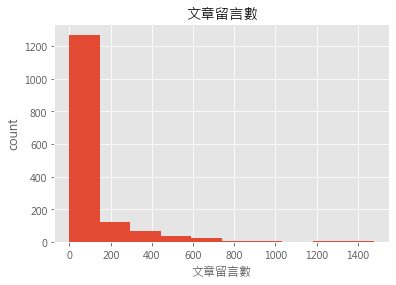

In [90]:
plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] #使中文能正常顯示
plt.hist(data["commentNum"])

plt.title('文章留言數')
plt.xlabel('文章留言數')
plt.ylabel('count')

依據發文數或回覆數篩選post和review

In [91]:
# 帳號發文篇數
pd.DataFrame(data.groupby("artPoster").size(),columns = ['count']).reset_index().sort_values(by="count",ascending=False)

,artPoster,count
268,butten986,18
287,chirex,16
703,smalltwo,10
767,uhbygv45,10
312,devidevi,10
...,...,...
380,goingmo,1
381,goldhan,1
59,FlyinDance56,1
383,goodbye,1


In [92]:
# 檢視人數
print("發文者數量總共:",len(set(posts_Reviews["artPoster"])))
print("回覆者數量總共:",len(set(posts_Reviews["cmtPoster"])))

發文者數量總共: 841
回覆者數量總共: 17402


**標記所有出現過的使用者**
- poster：只發過文、發過文+留過言
- replyer：只留過言

In [93]:
# 用set()得到不重複的集合
s = set(list(posts_Reviews["artPoster"])+list(posts_Reviews["cmtPoster"]))

In [94]:
allPoster = pd.DataFrame(list(s),columns=["user"])
allPoster["type"] = allPoster["user"].apply(lambda x: "poster" if x in list(data["artPoster"]) else "replayer")
allPoster.head(5)

,user,type
0,kemal969,replayer
1,a73229,replayer
2,zaqmlp,replayer
3,Government,poster
4,usokami,poster


### 6.6 以日期篩選社群

事件在12/01被討論次數最多，我們挑出當天的文章和回覆

In [95]:
# 篩選日期為2021-12-01 且 留言數>200的
posts_Reviews_1201 = (posts_Reviews.query('artDate == "2021-12-01"')
                      .query('commentNum>200')
                      .groupby(['cmtPoster','artUrl'],as_index=False).size()
                     )

In [96]:
# 篩選有人在同一篇文章重複回覆大於5次
posts_Reviews_1201 = posts_Reviews_1201.query('size>5')
posts_Reviews_1201.head(3)

,cmtPoster,artUrl,size
195,Annis812,https://www.ptt.cc/bbs/Gossiping/M.1638333384....,7
196,Annis812,https://www.ptt.cc/bbs/Gossiping/M.1638334280....,6
199,Annis812,https://www.ptt.cc/bbs/Gossiping/M.1638337220....,7


In [97]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_1201 = pd.merge(posts_Reviews_1201,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_1201.reset_index(inplace=True, drop=True) #重設index
link_1201.head(3)

,cmtPoster,artUrl,size,artPoster
0,Annis812,https://www.ptt.cc/bbs/Gossiping/M.1638333384....,7,hellogym
1,Annis812,https://www.ptt.cc/bbs/Gossiping/M.1638334280....,6,jimgene
2,Annis812,https://www.ptt.cc/bbs/Gossiping/M.1638337220....,7,pttjordy


In [98]:
# Create network plot 
# nx.Graph()為無向圖 ; nx.DiGraph()為有向圖
G = nx.Graph()

# 建立 nodes 間的連結
for i in range(0,len(link_1201)):
    G.add_edge(link_1201["cmtPoster"][i], link_1201["artPoster"][i])

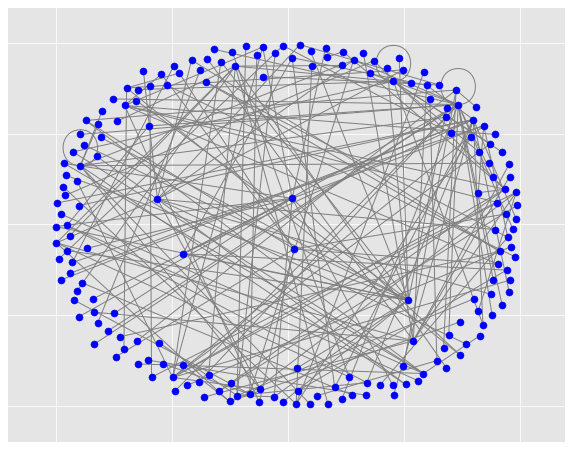

In [99]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color="blue",
                 with_labels = False,
                 ax=ax)
    
plt.show()

**加上nodes的顯示資訊**  
用使用者的身份來區分點的顏色
- poster:red(有發文)
- replyer:blue(只有回覆文章)

In [100]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

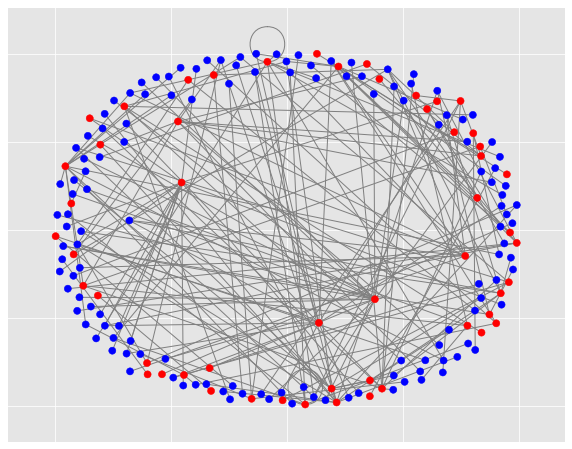

In [101]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)
    
plt.show()

為點加上帳號名字，用degree篩選要顯示出的使用者(degree>5)，以免圖形被密密麻麻的文字覆蓋。  

In [102]:
# 刪除degree<1的點
to_be_removed = [x for  x in G.nodes() if G.degree(x) <= 1]
for x in to_be_removed:
    G.remove_node(x)

In [103]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

In [104]:
# 找出degree>5的點
degrees = [node for (node, val) in G.degree() if val>5]
degrees

['hellogym', 'qishuv', 'zalora', 'duise', 'coffee112']

In [105]:
# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

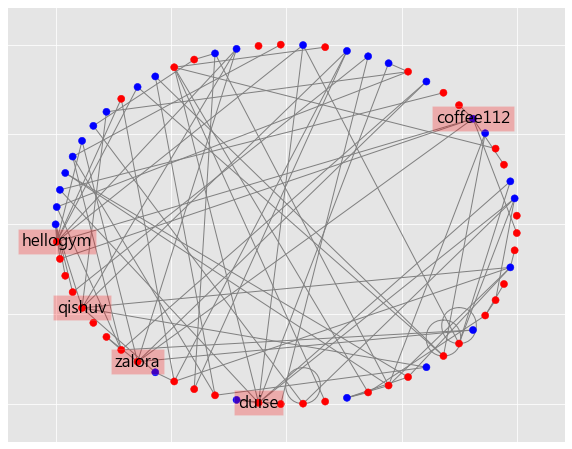

In [106]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
# pos = nx.spring_layout(G, k=2)
pos = nx.shell_layout(G)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    
plt.show()

**計算Centrality**  
找出重要的點  
[NetworkX Centrality](https://networkx.org/documentation/stable/reference/algorithms/centrality.html)  

- degree centrality: people with many connections tend to be important
- eigenvector centrality: people who are connected to more important people tend to be important
- pagerank centrality: remedy Eigenvector measure by normalization
- betweenness centrality: People who connect to more communities tend to be more important

In [107]:
# degree centrality
degree = nx.degree_centrality(G)
degree

{'Annis812': 0.078125,
 'hellogym': 0.109375,
 'jimgene': 0.03125,
 'pttjordy': 0.015625,
 'ArgusX': 0.03125,
 'qishuv': 0.109375,
 'DevilHotel': 0.0,
 'CPer': 0.03125,
 'kuloda': 0.078125,
 'zalora': 0.09375,
 'CYL009': 0.03125,
 'lycppt': 0.0625,
 'jiern': 0.03125,
 'jumomo': 0.046875,
 'Expend': 0.03125,
 'duise': 0.109375,
 'Israfil': 0.03125,
 'YumingHuang': 0.0625,
 'strellson': 0.015625,
 'Kennyq': 0.046875,
 'RenMian': 0.046875,
 'shinmoner': 0.078125,
 'GreenBeret': 0.046875,
 'Mradult': 0.03125,
 'semih': 0.078125,
 'zoe5566': 0.078125,
 'Thaichonburi': 0.03125,
 'VOLK11': 0.046875,
 'murray': 0.03125,
 'vwwv': 0.015625,
 'WarIII': 0.078125,
 'hiokchi': 0.015625,
 'lamigo520': 0.015625,
 'uhbygv45': 0.0,
 'aa01081008tw': 0.0625,
 'badmark369': 0.03125,
 'iamcnc': 0.015625,
 'a0580531': 0.015625,
 'chinhan1216': 0.03125,
 'coffee112': 0.09375,
 'runa2': 0.015625,
 'kobesuck': 0.015625,
 'duo0518': 0.03125,
 'novashine': 0.046875,
 'facebcck': 0.03125,
 'findwind0826': 0.03125,

In [108]:
# eigenvector centrality
eigenvector = nx.eigenvector_centrality(G)
# pagerank centrality
pr = nx.pagerank(G, alpha=0.9)
# betweenness centrality
between = nx.betweenness_centrality(G)

In [109]:
# 找出degree centrality最高的前5名
print("degree centrality:",sorted(degree, key=degree.get, reverse=True)[:5])

# 找出eigenvector centrality最高的前5名
print("eigenvector centrality:",sorted(eigenvector, key=eigenvector.get, reverse=True)[:5])

# 找出pagerank centrality最高的前5名
print("pagerank centrality:",sorted(pr, key=pr.get, reverse=True)[:5])

# 找出betweenness centrality最高的前5名
print("betweenness centrality:",sorted(between, key=between.get, reverse=True)[:5])

degree centrality: ['hellogym', 'qishuv', 'duise', 'zalora', 'coffee112']
eigenvector centrality: ['hellogym', 'qishuv', 'coffee112', 'zalora', 'Annis812']
pagerank centrality: ['duise', 'hellogym', 'qishuv', 'coffee112', 'panzerbug']
betweenness centrality: ['hellogym', 'duise', 'qishuv', 'gn0028526', 'WarIII']


### 6.7 以主題篩選社群

挑選出2021-12-01當天的文章， 篩選一篇文章回覆5次以上者，且文章留言數大於200則， 文章主題歸類為0(報導相關)與2(調侃)者， 欄位只取：cmtPoster(評論者), artPoster(發文者), artUrl(文章連結), topic(主題)

In [110]:
# 加上topic
topic_1201 = pd.merge(link_1201,posts_Reviews,on=["cmtPoster","artUrl"],how="left")[["cmtPoster","artUrl","topic"]].drop_duplicates()

In [111]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_1201_topic = pd.merge(topic_1201,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_1201_topic.reset_index(inplace=True, drop=True) #重設index
link_1201_topic.head(3)

,cmtPoster,artUrl,topic,artPoster
0,Annis812,https://www.ptt.cc/bbs/Gossiping/M.1638333384....,0,hellogym
1,Annis812,https://www.ptt.cc/bbs/Gossiping/M.1638334280....,0,jimgene
2,Annis812,https://www.ptt.cc/bbs/Gossiping/M.1638337220....,0,pttjordy


In [112]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結，及edge的顏色
color_map_edge = []
for i in range(0,len(link_1201_topic)):
    G.add_edge(link_1201_topic["cmtPoster"][i], link_1201_topic["artPoster"][i])
    if link_1201_topic["topic"][i] == 0: #以主題區分顏色
        color_map_edge.append('orange') # 主題零:報導相關
    else: 
        color_map_edge.append('grey') # 主題二:調侃相關   

In [113]:
# 刪除degree<1的點
to_be_removed = [x for  x in G.nodes() if G.degree(x) <= 1]
for x in to_be_removed:
    G.remove_node(x)

In [114]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

In [115]:
# 找出degree>5的點
degrees = [node for (node, val) in G.degree() if val>5]
degrees
# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

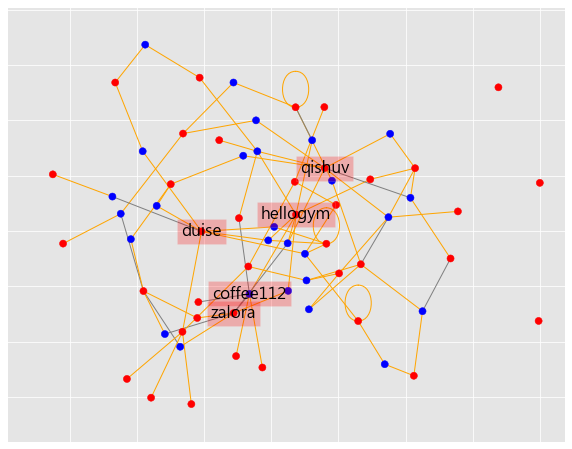

In [116]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G,k=0.3)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color=color_map_edge,
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    
plt.show()

報導主題相關為橘色，調侃相關為灰色。可以看出hellogym較多為PTT相關留言，coffee112較多是調侃文章留言。

### 6.8 使用者是否受到歡迎

PTT的回覆有三種，推文、噓文、箭頭，我們只要看推噓就好，因此把箭頭清掉。

In [117]:
# 加上status
status_1201 = pd.merge(link_1201,posts_Reviews,on=["cmtPoster","artUrl"],how="left")[["cmtPoster","artUrl","topic","cmtStatus"]].drop_duplicates()
# 去掉"→"的資料
status_1201 = status_1201[status_1201["cmtStatus"]!="→"]

In [118]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_1201_status = pd.merge(status_1201,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_1201_status.reset_index(inplace=True, drop=True) #重設index
link_1201_status.head(3)

,cmtPoster,artUrl,topic,cmtStatus,artPoster
0,Annis812,https://www.ptt.cc/bbs/Gossiping/M.1638333384....,0,推,hellogym
1,Annis812,https://www.ptt.cc/bbs/Gossiping/M.1638334280....,0,推,jimgene
2,Annis812,https://www.ptt.cc/bbs/Gossiping/M.1638337220....,0,推,pttjordy


In [119]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結，及edge的顏色
color_map_edge_S = []
for i in range(0,len(link_1201_status)):
    G.add_edge(link_1201_status["cmtPoster"][i], link_1201_status["artPoster"][i])
    if link_1201_status["cmtStatus"][i] == "推":
        color_map_edge_S.append('orange')
    else: 
        color_map_edge_S.append('grey')    

In [120]:
# 刪除degree<1的點
to_be_removed = [x for  x in G.nodes() if G.degree(x) <= 1]
for x in to_be_removed:
    G.remove_node(x)

In [121]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

In [122]:
# 找出degree>5的點
degrees = [node for (node, val) in G.degree() if val>5]

# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

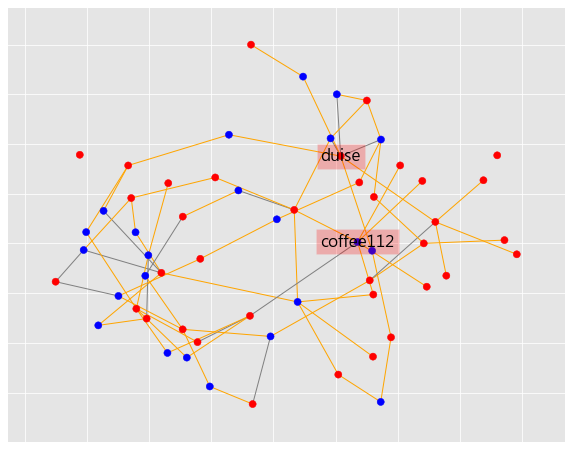

In [123]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=0.4)
# pos = nx.shell_layout(G)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color=color_map_edge_S,
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    
plt.show()

## 結論
+ 可以發現本次的討論中幾乎都是推文、噓文較少。